# Safety Experiments

Safety can be roughly translated as the agent avoiding bad trajectories (state/action).

We aim at improving the policy, so that the output of the safety function, i.e. how quantifiably safe
is my current state and action pair, is as small as possible.

**Specification of saftey requirements**

For this experiments, the requirements have been specified in the gym environment itself. We have set bounds for the Lander. If the Lander is flying inside these
pre-determined bounds, we say that the it acted safely. We quanity the risk of of the Lander by calculating the distance between the safety bounds and the coordinates of the Lander. In other words: the further away the Lander flies from the bounds, the unsafer we say it acted.

The main issue with this approach is the heuristic nature of the specifications. In real world applications, these would not be easy to find and may change anyway. 

**Approach and artefacts**

+ Directly improve the agent
    + Optimization methods
    + Black box falidation methods
+ Seperate controller




**Ressources**
+ https://rlss.inria.fr/files/2019/07/SafeRL_tutorial.pdf

## ToDo

### Importance sampling with CEM (off-policy)
+ https://towardsdatascience.com/solving-a-reinforcement-learning-problem-using-cross-entropy-method-23d9726a737
+ https://towardsdatascience.com/cross-entropy-method-for-reinforcement-learning-2b6de2a4f3a0

### Optimization with gaussian process (on-policy)
+ https://distill.pub/2019/visual-exploration-gaussian-processes/
+ https://distill.pub/2020/bayesian-optimization/

### Safety controller 
+ https://arxiv.org/pdf/1801.08757.pdf 
+ https://arxiv.org/pdf/2006.12136.pdf

### Black Box Validation: Advesary
+ https://ai.stanford.edu/blog/black-box-safety-validation/
+ https://arxiv.org/pdf/2005.02979.pdf

In [1]:
# Disable annoying tf2 warnings
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

import matplotlib
%matplotlib inline

import random
import gym
import gym_safety
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.9999
        self.epsilon_min = 0.001
        self.batch_size = 64
        self.train_start = 1000
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # initialize target model
        self.update_target_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        #model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    def save_model(self, filename):
        self.model.save(filename)

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    def append_sample(self, state, action, reward, next_state, done, bounds):
        self.memory.append((state, action, reward, next_state, done, bounds))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_network(self):
        if len(self.memory) < self.train_start:
            return
        
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)

        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * (np.amax(target_val[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

        
    def train_agent(self, episodes=1000, render=False):
        scores = []
        for e in range(episodes):
            done = False
            score = 0
            state = env.reset()
            state = np.reshape(state[:-2], [1, state_size])
            while not done:
                if render: env.render(mode='human')
                # get action for the current state and go one step in environment
                action = self.get_action(state)
                next_state, reward, done, info = env.step(action)
                bounds = np.reshape(next_state[-2:], [1, 2]) # seperate safety from other
                next_state = np.reshape(next_state[:-2], [1, state_size])

                self.append_sample(state, action, reward, next_state, done, bounds)

                self.update_network()
                score += reward
                state = next_state

                if done:
                    # every episode update the target model to be same with model
                    self.update_target_model()
                    # every episode, plot the play time
                    score = score if score == 500 else score + 100
                    scores.append(score)
                    print(f"episode: {e}  | " \
                          f"score: {score}  | " \
                          f"memory: {len(agent.memory)} | " \
                          f"epsilon: {agent.epsilon}")

                    # if the mean of scores of last 10 episode is bigger than 490
                    # stop training
                    if np.mean(scores[-min(10, len(scores)):]) > 490:
                        return
        return scores

    # pretty hacky but ok
    def get_safe_bounds(self):
        return [(i[0][0][-1], i[0][0][-2]) for i in memory]
        

In [4]:
EPISODES = 300
env = gym.make('LunarSafe-v0')

# get size of state and action from environment
state_size = env.observation_space.shape[0] - 2
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size)
scores = agent.train_agent(episodes=EPISODES)
agent.save_model('dqn-lunar-safe-nostate.h2')

episode: 0  | score: -133.83762774579037  | memory: 128 | epsilon: 0.9872809396881612
episode: 1  | score: -51.848263006419415  | memory: 229 | epsilon: 0.9773590957567164
episode: 2  | score: 12.206216694663127  | memory: 301 | epsilon: 0.9703470333764725
episode: 3  | score: 10.159873788027127  | memory: 366 | epsilon: 0.9640599185586783
episode: 4  | score: -88.52659380162527  | memory: 430 | epsilon: 0.9579093304224501
episode: 5  | score: -141.01445283244973  | memory: 520 | epsilon: 0.9493263984264878
episode: 6  | score: -153.18340302697572  | memory: 605 | epsilon: 0.9412909214192257
episode: 7  | score: -72.39322921797299  | memory: 674 | epsilon: 0.9348180475097226
episode: 8  | score: 10.937051276480574  | memory: 735 | epsilon: 0.9291327309948104
episode: 9  | score: -323.6074562458463  | memory: 833 | epsilon: 0.9200712509273935
episode: 10  | score: -72.43903265305704  | memory: 906 | epsilon: 0.9133788531433524
episode: 11  | score: -167.4462703676828  | memory: 1029 | e

<AxesSubplot:xlabel='episode', ylabel='score'>

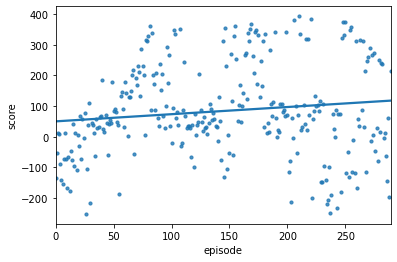

In [5]:
def reject_outliers(data, m=2):
    mean = np.mean(data)
    std = np.std(data)
    distance = abs(data - mean)
    not_outlier = distance < m * std
    return data[not_outlier]

scores = reject_outliers(np.array(scores))
df = pd.DataFrame([(i, v) for i, v in enumerate(scores)], columns=["episode", "score"])
sns.regplot(x="episode", y="score", data=df, robust=True, ci=None, scatter_kws={"s": 10})

<AxesSubplot:>

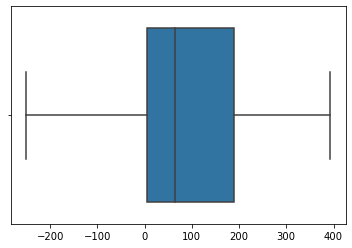

In [6]:
sns.boxplot(scores, showfliers=False)

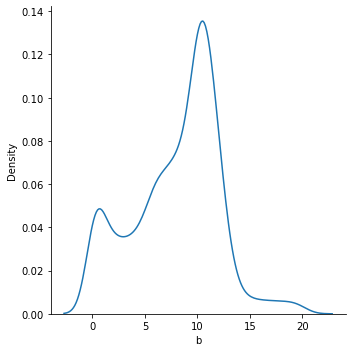

In [7]:
bounds = [i[-1:][0][0] for i in agent.memory]
df = pd.DataFrame([(abs(v[0]-v[1])) for i, v in enumerate(bounds)], columns=["b"])
sns.displot(df, x="b", kind="kde")